# Foreground Background Seperation via Pixel Mask and Red Sequency Members 

### Imports

In [3]:
from astropy.table import Table, vstack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import ipywidgets as widgets
from matplotlib.colors import ListedColormap
from scipy import ndimage
from matplotlib.colors import to_rgba

### Load in Redshift Data and the Full Cluster Catalog

In [4]:
# Data file paths
# Replace with your own /path/to/data
REDSHIFT_CATALOG = '/scratch/sa.saha/data/mega_color_mag_with_redshift_20250811_141642.fits'  # Training data with known redshifts
FULL_CATALOG = '/scratch/sa.saha/data/mega_color_mag_catalog_20250811_141158.fits'            # Full catalog

# Load the redshift catalog (for visualization and validation)
print("Loading redshift catalog for training/validation...")
redshift_cat = Table.read(REDSHIFT_CATALOG)
print(f"Loaded {len(redshift_cat)} objects with known redshifts")

# Load the full catalog (for applying cuts)
print("\nLoading full photometric catalog...")
full_cat = Table.read(FULL_CATALOG)
print(f"Loaded {len(full_cat)} total objects")

# Display available columns
print(f"\nAvailable columns: {full_cat.colnames}")

Loading redshift catalog for training/validation...


Loaded 22031 objects with known redshifts

Loading full photometric catalog...
Loaded 249978 total objects

Available columns: ['FLUXERR_AUTO_b', 'FLUXERR_AUTO_g', 'FLUXERR_AUTO_u', 'FLUX_AUTO_b', 'FLUX_AUTO_g', 'FLUX_AUTO_u', 'OBJTYPE', 'PROGRAM', 'R_b', 'R_b_prepsf', 'R_g', 'R_g_prepsf', 'R_u', 'R_u_prepsf', 'SNR_b', 'SNR_combined', 'SNR_g', 'SNR_u', 'SPECTYPE', 'SURVEY', 'TARGETID', 'TARGET_DEC', 'TARGET_RA', 'VIGNET_b', 'VIGNET_g', 'VIGNET_u', 'Z', 'ZCAT_NSPEC', 'ZCAT_PRIMARY', 'ZERR', 'ZERR_best', 'ZERR_desi', 'ZERR_lovoccs', 'ZWARN', 'Z_best', 'Z_desi', 'Z_lovoccs', 'Z_ned', 'Z_source', 'color_bg', 'color_bg_err', 'color_ub', 'color_ub_err', 'dec', 'id', 'm_b', 'm_b_err', 'm_g', 'm_g_err', 'm_u', 'm_u_err', 'ra', 'CLUSTER']


In [5]:
redshift = redshift_cat['Z_best'].astype(float)
color_bg = redshift_cat['color_bg'].astype(float)  # B-G color *includes lovoccs*
color_ub = redshift_cat['color_ub'].astype(float)  # U-B color
color_bg_err = redshift_cat['color_bg_err'].astype(float)
color_ub_err = redshift_cat['color_ub_err'].astype(float)
redshift_err = redshift_cat["ZERR_best"].astype(float)
redshift_source = np.array([s.strip() for s in redshift_cat['Z_source']])

print("Data summary:")
print(f"Redshift range: {np.nanmin(redshift):.3f} to {np.nanmax(redshift):.3f}")
print(f"B-G color range: {np.nanmin(color_bg):.3f} to {np.nanmax(color_bg):.3f}")
print(f"U-B color range: {np.nanmin(color_ub):.3f} to {np.nanmax(color_ub):.3f}")
print(f"Redshift sources: {np.unique(redshift_source)}")

Data summary:
Redshift range: -0.001 to 6.640
B-G color range: -86.240 to 79.591
U-B color range: -79.152 to 86.911
Redshift sources: ['DESI' 'LoVoCCS' 'NED']


### Load in the red sequence data 
This is yet to be automated 

In [6]:
# Red Sequence Members 
Abell3411_imposters = Table.read('/projects/mccleary_group/ysp/redseq/Abell3411/Abell3411_imposter_members_catalog.fits')
Abell3411_actual = Table.read('/projects/mccleary_group/ysp/redseq/Abell3411/Abell3411_actual_members_catalog.fits')

## Define Cluster

In [7]:
Z_THRESH = 0.193 
ERR_THRESH = 0.5
CLUSTER_NAME = 'Abell3411'
XLIM = (0, 2.5)    
YLIM = (-2, 3)    

In [8]:
# Valid redshift sources (NED and DESI are most reliable)
reliable_sources_mask = (redshift_source == "NED")

# Good color measurements (low errors)
good_colors_mask = (color_bg_err < ERR_THRESH) & (color_ub_err < ERR_THRESH)

# No NaN values in colors or redshift
valid_data_mask = ~(np.isnan(color_bg) | np.isnan(color_ub) | np.isnan(redshift))

# Combined mask for "training"
training_mask = reliable_sources_mask & good_colors_mask & valid_data_mask

# Background vs foreground classification
background_mask = redshift > Z_THRESH  # Objects behind the cluster
foreground_mask = redshift < Z_THRESH  # Objects in front of the cluster

# Calculate data quality statistics
total_objects = len(redshift)
nan_objects = np.sum(~valid_data_mask)
high_error_objects = np.sum(~good_colors_mask & valid_data_mask)  # Valid data but high errors
unreliable_sources = np.sum(~reliable_sources_mask)

## Functions

In [9]:
def create_pixel_voting_map_purity(color_bg, color_ub, redshift, z_thresh, xlim, ylim, 
                                  pixel_size=0.1, training_mask=None, purity_threshold=0.75):
    """
    Create a pixel-based voting map in color-color space with purity threshold.
    Each pixel is colored based on whether foreground (blue) objects meet the purity threshold.
    
    Parameters
    ----------
    color_bg, color_ub : array-like
        B-G and U-B colors
    redshift : array-like
        Redshift values
    z_thresh : float
        Redshift threshold for background/foreground split
    xlim, ylim : tuple
        Plot limits for color axes
    pixel_size : float
        Size of each pixel in color space
    training_mask : boolean array, optional
        Mask for high-quality training data
    purity_threshold : float
        Minimum fraction of foreground objects needed for pixel to be blue (default 0.75)
        
    Returns
    -------
    vote_map : 2D array
        Voting results: 1 for red (background-dominated or below purity), 
        -1 for blue (foreground purity >= threshold)
    x_edges, y_edges : array
        Bin edges for the pixel grid
    bg_hist, fg_hist : 2D arrays
        Object counts for background and foreground populations
    """
    
    if training_mask is not None:
        color_bg = color_bg[training_mask]
        color_ub = color_ub[training_mask]
        redshift = redshift[training_mask]
    
    # Remove NaN values
    valid_mask = ~(np.isnan(color_bg) | np.isnan(color_ub) | np.isnan(redshift))
    color_bg = color_bg[valid_mask]
    color_ub = color_ub[valid_mask]
    redshift = redshift[valid_mask]
    
    # Create redshift masks
    background_mask = redshift > z_thresh  # High-z (background, RED)
    foreground_mask = redshift <= z_thresh  # Low-z (foreground, BLUE)
    
    # Create pixel grid
    x_edges = np.arange(xlim[0], xlim[1] + pixel_size, pixel_size)
    y_edges = np.arange(ylim[0], ylim[1] + pixel_size, pixel_size)
    
    # Create 2D histograms for each population
    bg_hist, _, _ = np.histogram2d(color_bg[background_mask], color_ub[background_mask], 
                                  bins=[x_edges, y_edges])
    fg_hist, _, _ = np.histogram2d(color_bg[foreground_mask], color_ub[foreground_mask], 
                                  bins=[x_edges, y_edges])
    
    # Create voting map based on purity threshold
    vote_map = np.zeros_like(bg_hist)
    
    # Calculate total objects per pixel
    total_objects = bg_hist + fg_hist
    has_objects = total_objects > 0
    
    # Calculate purity (fraction of foreground objects)
    purity = np.zeros_like(bg_hist)
    purity[has_objects] = fg_hist[has_objects] / total_objects[has_objects]
    
    # Apply purity threshold: blue (-1) if purity >= threshold, red (+1) otherwise
    vote_map[has_objects] = np.where(purity[has_objects] >= purity_threshold, -1, 1)
    
    return vote_map, x_edges, y_edges, bg_hist, fg_hist, total_objects

In [10]:
def plot_pixel_voting_map(color_bg, color_ub, redshift, z_thresh, xlim, ylim, 
                                training_mask, cluster_name, pixel_size=0.1, 
                                show_scatter=True, show_counts=True, min_count_display=1,
                                purity_threshold=0.75, blue_counts_only=False, 
                                show_cluster_objects=False, full_catalog=None,
                                redshift_seq=False, imposters_catalog=None, actual_catalog=None,
                                show_mask=False, figsize=(10, 8)):
    """
    Plot pixel-based voting map with purity threshold and optional object counts.
    
    Parameters
    ----------
    [Previous parameters...]
    show_mask : bool
        If True, color BLUE pixels with >=10 objects green, or magenta if they contain actual members
    """
    
    # Create voting map with purity threshold
    vote_map, x_edges, y_edges, bg_hist, fg_hist, total_objects = create_pixel_voting_map_purity(
        color_bg, color_ub, redshift, z_thresh, xlim, ylim, 
        pixel_size, training_mask, purity_threshold
    )
    
    # Apply mask coloring if requested
    if show_mask and actual_catalog is not None:
        # Make a copy of vote_map to modify
        vote_map_display = vote_map.copy()
        
        # Find BLUE pixels with >= 10 objects
        blue_high_count_pixels = (vote_map == -1) & (total_objects >= 10)
        
        # Set these pixels to a special value (2 for green)
        vote_map_display[blue_high_count_pixels] = 2
        
        # Check if actual members fall in these pixels
        if len(actual_catalog) > 0:
            act_bg = actual_catalog['color_bg'].astype(float)
            act_ub = actual_catalog['color_ub'].astype(float)
            act_valid = ~(np.isnan(act_bg) | np.isnan(act_ub))
            act_bg, act_ub = act_bg[act_valid], act_ub[act_valid]
            
            # Find which pixels contain actual members
            for bg_val, ub_val in zip(act_bg, act_ub):
                # Find pixel indices
                i = np.searchsorted(x_edges, bg_val) - 1
                j = np.searchsorted(y_edges, ub_val) - 1
                
                # Check bounds
                if 0 <= i < len(x_edges)-1 and 0 <= j < len(y_edges)-1:
                    # If this is a blue high-count pixel, mark it as magenta (value 3)
                    if blue_high_count_pixels[i, j]:
                        vote_map_display[i, j] = 3
    else:
        vote_map_display = vote_map
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create custom colormap based on show_mask
    if show_mask:
        # Extended colormap: blue (-1), white (0), red (1), green (2), magenta (3)
        colors = ['blue', 'white', 'red', 'green', 'magenta']
        colors_with_alpha = [
            to_rgba('blue', alpha=0.4),    # 30% opacity
            to_rgba('white', alpha=1.0),   # Fully opaque
            to_rgba('red', alpha=0.4),     # 30% opacity
            to_rgba('green', alpha=1.0),   # Fully opaque
            to_rgba('magenta', alpha=1.0)  # Fully opaque
        ]
        cmap = ListedColormap(colors_with_alpha)
        vmin, vmax = -1, 3
    else:
        # Original colormap
        colors = ['blue', 'white', 'red']
        cmap = ListedColormap(colors)
        vmin, vmax = -1, 1
    
    # Plot voting map
    im = ax.imshow(vote_map_display.T, extent=[xlim[0], xlim[1], ylim[0], ylim[1]], 
                   origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.7, aspect='auto')
    
    # Add cluster objects if requested
    if show_cluster_objects:
        if full_catalog is None:
            print("Warning: show_cluster_objects=True but full_catalog not provided")
        else:
            # Filter for cluster objects
            cluster_mask = full_catalog['CLUSTER'] == cluster_name
            cluster_objects = full_catalog[cluster_mask]
            
            if len(cluster_objects) > 0:
                # Extract colors for cluster objects
                cluster_bg = cluster_objects['color_bg'].astype(float)
                cluster_ub = cluster_objects['color_ub'].astype(float)
                
                # Remove NaN values
                valid_cluster = ~(np.isnan(cluster_bg) | np.isnan(cluster_ub))
                cluster_bg = cluster_bg[valid_cluster]
                cluster_ub = cluster_ub[valid_cluster]
                
                # Plot cluster objects in grey
                ax.scatter(cluster_bg, cluster_ub, c='grey', alpha=0.5, s=10, 
                          label=f'{cluster_name} objects', edgecolors='none', zorder=1)
                
                print(f"Plotted {len(cluster_bg)} cluster objects from {cluster_name}")
            else:
                print(f"No objects found for cluster {cluster_name}")
    
    # Add redshift sequence members if requested
    if redshift_seq:
        if imposters_catalog is None or actual_catalog is None:
            print("Warning: redshift_seq=True but imposters_catalog or actual_catalog not provided")
        else:
            # Plot imposters
            if imposters_catalog is not None and len(imposters_catalog) > 0:
                imp_bg = imposters_catalog['color_bg'].astype(float)
                imp_ub = imposters_catalog['color_ub'].astype(float)
                imp_valid = ~(np.isnan(imp_bg) | np.isnan(imp_ub))
                imp_bg, imp_ub = imp_bg[imp_valid], imp_ub[imp_valid]
                
                ax.scatter(imp_bg, imp_ub, c='orange', alpha=1, s=15, 
                          label=f'Imposters ({len(imp_bg)})', edgecolors='black', zorder=3)
                print(f"Plotted {len(imp_bg)} imposter members")
            
            # Plot actual members
            if actual_catalog is not None and len(actual_catalog) > 0:
                act_bg = actual_catalog['color_bg'].astype(float)
                act_ub = actual_catalog['color_ub'].astype(float)
                act_valid = ~(np.isnan(act_bg) | np.isnan(act_ub))
                act_bg, act_ub = act_bg[act_valid], act_ub[act_valid]
                
                ax.scatter(act_bg, act_ub, c='magenta', alpha=1, s=15, 
                          label=f'Actual Members ({len(act_bg)})', edgecolors='black', zorder=3)
                print(f"Plotted {len(act_bg)} actual members")
    
    # Add object counts if requested
    if show_counts:
        # Get pixel centers
        x_centers = (x_edges[:-1] + x_edges[1:]) / 2
        y_centers = (y_edges[:-1] + y_edges[1:]) / 2
        count_sum = 0
        
        # Add text for pixels with enough objects
        for i, x in enumerate(x_centers):
            for j, y in enumerate(y_centers):
                count = int(total_objects[i, j])
                
                # Decide whether to show count
                if blue_counts_only:
                    # Show count only if pixel is blue (vote_map == -1)
                    show_this_count = (vote_map[i, j] == -1) and (count > 0) and count >= 10
                    if show_this_count:
                        count_sum = count_sum + 1
                        
                else:
                    # Show count if above minimum threshold
                    show_this_count = (count >= min_count_display)
                    
                
                if show_this_count:
                    # Choose text color based on background
                    if show_mask and vote_map_display[i, j] in [2, 3]:  # Green or magenta
                        text_color = 'black'
                    else:
                        text_color = 'white' if vote_map[i, j] != 0 else 'black'
                    ax.text(x, y, str(count), ha='center', va='center', 
                           fontsize=8, color=text_color, weight='bold', zorder=4)
        print(count_sum)
    
    # Add scatter points if requested
    if show_scatter:
        train_bg = color_bg[training_mask] if training_mask is not None else color_bg
        train_ub = color_ub[training_mask] if training_mask is not None else color_ub
        train_z = redshift[training_mask] if training_mask is not None else redshift
        
        # Remove NaNs for plotting
        valid = ~(np.isnan(train_bg) | np.isnan(train_ub) | np.isnan(train_z))
        train_bg, train_ub, train_z = train_bg[valid], train_ub[valid], train_z[valid]
        
        background_mask = train_z > z_thresh
        foreground_mask = train_z <= z_thresh
        
        if np.any(background_mask):
            ax.scatter(train_bg[background_mask], train_ub[background_mask], 
                      c='red', alpha=0.3, s=3, label=f'Background (z > {z_thresh})', 
                      edgecolors='none', zorder=2)
        
        if np.any(foreground_mask):
            ax.scatter(train_bg[foreground_mask], train_ub[foreground_mask], 
                      c='blue', alpha=0.3, s=3, label=f'Foreground (z ≤ {z_thresh})', 
                      edgecolors='none', zorder=2)
    
    ax.set_xlabel('B - G Color')
    ax.set_ylabel('U - B Color')
    
    # Update title based on show_mask
    if show_mask:
        ax.set_title(f'{cluster_name}: Pixel Mask (Blue pixels with ≥10 objects)\n'
                     f'Green = High count blue pixels, Magenta = Contains actual members')
    else:
        ax.set_title(f'{cluster_name}: Pixel Voting Map (purity ≥ {purity_threshold:.0%})\n'
                     f'Blue = Foreground purity ≥ {purity_threshold:.0%}, Red = Otherwise')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add statistics
    has_objects = total_objects > 0
    total_pixels = np.sum(has_objects)
    
    if show_mask:
        # Count mask pixels (only from originally blue pixels)
        green_pixels = np.sum(vote_map_display == 2)
        magenta_pixels = np.sum(vote_map_display == 3)
        blue_high_count_total = green_pixels + magenta_pixels
        
        stats_text = f'Blue Pixel Mask Statistics (size={pixel_size}):\n'
        stats_text += f'Blue pixels with ≥10 objects: {blue_high_count_total}\n'
        stats_text += f'Green (no actual members): {green_pixels}\n'
        stats_text += f'Magenta (contains actual members): {magenta_pixels}'
    else:
        blue_pixels = np.sum(vote_map == -1)
        red_pixels = np.sum(vote_map == 1)
        
        # Calculate purity for statistics
        purity = np.zeros_like(fg_hist, dtype=float)
        purity[has_objects] = fg_hist[has_objects] / total_objects[has_objects]
        
        stats_text = f'Pixel Statistics (size={pixel_size}, purity threshold={purity_threshold:.0%}):\n'
        stats_text += f'Total pixels with objects: {total_pixels}\n'
        stats_text += f'Blue pixels (purity ≥ {purity_threshold:.0%}): {blue_pixels} ({blue_pixels/total_pixels*100:.1f}%)\n'
        stats_text += f'Red pixels (purity < {purity_threshold:.0%}): {red_pixels} ({red_pixels/total_pixels*100:.1f}%)'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    if show_mask:
        print(f"\nBlue Pixel Mask Analysis (≥10 objects per pixel):")
        print(f"Pixel size: {pixel_size}")
        print(f"Blue pixels with ≥10 objects: {blue_high_count_total}")
        print(f"Green pixels (no actual members): {green_pixels}")
        print(f"Magenta pixels (contains actual members): {magenta_pixels}")
        if blue_high_count_total > 0:
            print(f"Percentage with actual members: {magenta_pixels/blue_high_count_total*100:.1f}%")
    else:
        print(f"\nPixel Voting Analysis with Purity Threshold ({purity_threshold:.0%}):")
        print(f"Pixel size: {pixel_size}")
        print(f"Total pixels with objects: {total_pixels}")
        blue_pixels = np.sum(vote_map == -1)
        red_pixels = np.sum(vote_map == 1)
        print(f"Blue pixels (foreground purity ≥ {purity_threshold:.0%}): {blue_pixels} ({blue_pixels/total_pixels*100:.1f}%)")
        print(f"Red pixels (foreground purity < {purity_threshold:.0%}): {red_pixels} ({red_pixels/total_pixels*100:.1f}%)")
    
    if show_counts:
        if blue_counts_only:
            print(f"\nShowing object counts for blue pixels only")
        else:
            print(f"\nShowing object counts for pixels with ≥ {min_count_display} objects")
    
    if show_mask and actual_catalog is not None:
        return vote_map_display, x_edges, y_edges, bg_hist, fg_hist, total_objects
    else:
        return vote_map, x_edges, y_edges, bg_hist, fg_hist, total_objects

In [11]:
def apply_pixel_mask_to_catalog(vote_map_display, x_edges, y_edges, full_catalog, cluster_name, 
                               pixel_size, show_mask=True, save_to="./", 
                               pixel_method_only=True, pixel_with_redseq=False, 
                               actual_catalog=None):
    """
    Apply the pixel mask to the full catalog and save foreground objects.
    
    Parameters
    ----------
    vote_map_display : 2D array
        The voting map with mask values (2=green, 3=magenta)
    x_edges, y_edges : array
        Bin edges for the pixel grid
    full_catalog : astropy.table.Table
        Full catalog containing all objects
    cluster_name : str
        Name of the cluster to filter for
    pixel_size : float
        Size of each pixel (for verification)
    show_mask : bool
        Whether the mask was applied (if False, use blue pixels instead)
    save_to : str
        Directory path where the FITS file will be saved (default: current directory)
    pixel_method_only : bool
        If True, save only pixel-selected objects (default: True)
    pixel_with_redseq : bool
        If True, include actual red sequence members in addition to pixel-selected
    actual_catalog : astropy.table.Table or None
        Catalog of actual red sequence members (required if pixel_with_redseq=True)
        
    Returns
    -------
    masked_catalog : astropy.table.Table
        Catalog containing selected foreground objects
    """
    
    # First, filter for the specific cluster
    cluster_mask = full_catalog['CLUSTER'] == cluster_name
    cluster_objects = full_catalog[cluster_mask]
    
    if len(cluster_objects) == 0:
        print(f"No objects found for cluster {cluster_name}")
        return Table()
    
    print(f"Found {len(cluster_objects)} objects for {cluster_name}")
    
    # Extract colors
    obj_bg = cluster_objects['color_bg'].astype(float)
    obj_ub = cluster_objects['color_ub'].astype(float)
    
    # Remove objects with NaN colors
    valid_colors = ~(np.isnan(obj_bg) | np.isnan(obj_ub))
    valid_indices = np.where(valid_colors)[0]
    
    obj_bg = obj_bg[valid_colors]
    obj_ub = obj_ub[valid_colors]
    
    print(f"Objects with valid colors: {len(obj_bg)}")
    
    # Initialize mask for objects to keep
    keep_objects = np.zeros(len(obj_bg), dtype=bool)
    
    # Check which objects fall into masked pixels
    for idx, (bg_val, ub_val) in enumerate(zip(obj_bg, obj_ub)):
        # Find pixel indices
        i = np.searchsorted(x_edges, bg_val) - 1
        j = np.searchsorted(y_edges, ub_val) - 1
        
        # Check bounds
        if 0 <= i < len(x_edges)-1 and 0 <= j < len(y_edges)-1:
            if show_mask:
                # Keep objects in green (2) or magenta (3) pixels
                if vote_map_display[i, j] in [2, 3]:
                    keep_objects[idx] = True
            else:
                # If no mask, keep objects in blue pixels (-1)
                if vote_map_display[i, j] == -1:
                    keep_objects[idx] = True
    
    # Apply the mask to get pixel-selected catalog
    final_indices = valid_indices[keep_objects]
    masked_catalog = cluster_objects[final_indices]
    
    # Add red sequence members if requested
    if pixel_with_redseq and actual_catalog is not None:
        # Filter actual catalog for this cluster if needed
        if 'CLUSTER' in actual_catalog.colnames:
            actual_cluster = actual_catalog[actual_catalog['CLUSTER'] == cluster_name]
        else:
            actual_cluster = actual_catalog
        
        # Combine catalogs, removing duplicates based on 'id' column
        if len(actual_cluster) > 0:
            combined_ids = set(masked_catalog['id'])
            new_members = actual_cluster[~np.isin(actual_cluster['id'], list(combined_ids))]
            masked_catalog = vstack([masked_catalog, new_members])
            print(f"Added {len(new_members)} unique red sequence members")
    elif pixel_with_redseq and actual_catalog is None:
        print("Warning: pixel_with_redseq=True but actual_catalog not provided")
    
    # Print summary statistics
    n_kept = len(masked_catalog)
    n_total = len(cluster_objects)
    
    if show_mask:
        # Count how many are in green vs magenta pixels (for pixel-only selection)
        n_green = 0
        n_magenta = 0
        
        for idx in np.where(keep_objects)[0]:
            bg_val = obj_bg[idx]
            ub_val = obj_ub[idx]
            i = np.searchsorted(x_edges, bg_val) - 1
            j = np.searchsorted(y_edges, ub_val) - 1
            
            if 0 <= i < len(x_edges)-1 and 0 <= j < len(y_edges)-1:
                if vote_map_display[i, j] == 2:
                    n_green += 1
                elif vote_map_display[i, j] == 3:
                    n_magenta += 1
        
        print(f"\nMask Application Results:")
        print(f"Total {cluster_name} objects: {n_total}")
        print(f"Objects in masked pixels: {np.sum(keep_objects)} ({np.sum(keep_objects)/n_total*100:.1f}%)")
        print(f"  - In green pixels: {n_green}")
        print(f"  - In magenta pixels: {n_magenta}")
        if pixel_with_redseq:
            print(f"Total foreground objects (including red sequence): {n_kept}")
    else:
        print(f"\nBlue Pixel Selection Results:")
        print(f"Total {cluster_name} objects: {n_total}")
        print(f"Objects in blue pixels: {n_kept} ({n_kept/n_total*100:.1f}%)")
    
    # Save to file
    import os
    if pixel_with_redseq:
        filename = f'{cluster_name}_foreground_pixel_and_redseq.fits'
    else:
        filename = f'{cluster_name}_foreground_pixel.fits'
    filepath = os.path.join(save_to, filename)
    masked_catalog.write(filepath, overwrite=True)
    print(f"\nSaved {len(masked_catalog)} foreground galaxies to {filepath}")
    
    return masked_catalog

In [12]:
def spatial_plot(fits_file, vote_map_display, x_edges, y_edges, cluster_name, 
                 include_members=False, actual_catalog=None, figsize=(16, 6)):
    """
    Plot spatial distribution with scatter and density views.
    
    Parameters
    ----------
    fits_file : str
        Path to foreground catalog FITS file
    vote_map_display : 2D array
        Voting map for pixel classification
    x_edges, y_edges : array
        Bin edges for pixel classification
    cluster_name : str
        Cluster name for title
    include_members : bool
        If True, overlay actual cluster members
    actual_catalog : Table or str
        Actual members catalog (required if include_members=True)
    """
    
    # Load foreground catalog
    foreground = Table.read(fits_file)
    fg_ra = foreground['ra'].data.astype(float)
    fg_dec = foreground['dec'].data.astype(float)
    fg_bg = foreground['color_bg'].data.astype(float)
    fg_ub = foreground['color_ub'].data.astype(float)
    
    # Classify each object as green or magenta
    green_mask = np.zeros(len(fg_ra), dtype=bool)
    magenta_mask = np.zeros(len(fg_ra), dtype=bool)
    
    for idx in range(len(fg_ra)):
        i = np.searchsorted(x_edges, fg_bg[idx]) - 1
        j = np.searchsorted(y_edges, fg_ub[idx]) - 1
        
        if 0 <= i < len(x_edges)-1 and 0 <= j < len(y_edges)-1:
            if vote_map_display[i, j] == 2:
                green_mask[idx] = True
            elif vote_map_display[i, j] == 3:
                magenta_mask[idx] = True
    
    # Load actual catalog if needed
    if include_members:
        if isinstance(actual_catalog, str):
            actual = Table.read(actual_catalog)
        else:
            actual = actual_catalog
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Left panel: Scatter plot
    ax1.scatter(fg_ra[green_mask], fg_dec[green_mask], c='green', alpha=0.6, s=20,
               label=f'Green pixels ({np.sum(green_mask)})', edgecolors='darkgreen', linewidth=0.5)
    ax1.scatter(fg_ra[magenta_mask], fg_dec[magenta_mask], c='magenta', alpha=0.8, s=30,
               label=f'Magenta pixels ({np.sum(magenta_mask)})', edgecolors='purple', linewidth=0.5)
    
    if include_members and actual is not None:
        ax1.scatter(actual['ra'].data, actual['dec'].data, c='purple', s=100, marker='*',
                   label=f'Actual Members ({len(actual)})', 
                   edgecolors='black', linewidth=1.5)
    
    ax1.set_xlabel('RA (degrees)')
    ax1.set_ylabel('Dec (degrees)')
    title = f'{cluster_name}: Foreground vs Actual Members' if include_members else f'{cluster_name}: Spatial Distribution of Foreground Galaxies'
    ax1.set_title(title)
    ax1.invert_xaxis()
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Right panel: Density map
    if include_members and actual is not None:
        # Combine foreground (green+magenta) with actual members
        mask_combined = green_mask | magenta_mask
        all_ra = np.concatenate([fg_ra[mask_combined], actual['ra'].data])
        all_dec = np.concatenate([fg_dec[mask_combined], actual['dec'].data])
    else:
        # Only green and magenta pixels
        mask_combined = green_mask | magenta_mask
        all_ra = fg_ra[mask_combined]
        all_dec = fg_dec[mask_combined]
    
    ra_range = [all_ra.min(), all_ra.max()]
    dec_range = [all_dec.min(), all_dec.max()]
    
    bins_ra = int((ra_range[1] - ra_range[0]) / 0.005)  
    bins_dec = int((dec_range[1] - dec_range[0]) / 0.005)
    
    H, ra_edges_hist, dec_edges_hist = np.histogram2d(all_ra, all_dec, 
                                                      bins=[bins_ra, bins_dec],
                                                      range=[ra_range, dec_range])
    
    from scipy.ndimage import gaussian_filter
    H_smooth = gaussian_filter(H, sigma=1.5)
    
    extent = [ra_edges_hist[0], ra_edges_hist[-1], dec_edges_hist[0], dec_edges_hist[-1]]
    im = ax2.imshow(H_smooth.T, extent=extent, origin='lower', 
                    cmap='plasma', aspect='equal', interpolation='bilinear')
    
    cbar = plt.colorbar(im, ax=ax2, label='Count')
    
    ax2.set_xlabel('RA (degrees)')
    ax2.set_ylabel('Dec (degrees)')
    ax2.set_title(f'Resolution: 0.5 arcmin, kernel: 1.5')
    ax2.invert_xaxis()
    ax2.set_xlim(ra_range[::-1])  # reverse ra order
    ax2.set_ylim(dec_range)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Loaded {len(foreground)} foreground galaxies")
    print(f"Green pixels: {np.sum(green_mask)}, Magenta pixels: {np.sum(magenta_mask)}")
    
    if include_members:
        return fg_ra[green_mask], fg_dec[green_mask], fg_ra[magenta_mask], fg_dec[magenta_mask], actual
    else:
        return fg_ra[green_mask], fg_dec[green_mask], fg_ra[magenta_mask], fg_dec[magenta_mask]

In [13]:
def plot_radial_distribution_rb(fits_file, cluster_name, actual_catalog=None, figsize=(10, 6)):
    """Plot radial distribution of foreground galaxies and actual members overlaid."""
    
    # Read foreground catalog
    cat = Table.read(fits_file)
    r_b_pixel = cat['R_b'].astype(float)
    r_b = r_b_pixel * 0.141
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot foreground galaxies first (behind)
    n1, bins, patches1 = ax.hist(r_b, bins=30, alpha=0.6, color='blue', 
                                 edgecolor='black', label=f'Foreground ({len(cat)})')
    
    # Plot actual members if provided (in front)
    if actual_catalog is not None:
        actual_r_b_pixel = actual_catalog['R_b'].astype(float)
        actual_r_b = actual_r_b_pixel * 0.141
        
        n2, bins, patches2 = ax.hist(actual_r_b, bins=bins, alpha=0.7, color='magenta', 
                                     edgecolor='black', label=f'Actual Members ({len(actual_catalog)})')
        
        # Add median lines
        ax.axvline(np.median(r_b), color='darkblue', linestyle='--', linewidth=2,
                  label=f'Foreground Median: {np.median(r_b):.2f}')
        ax.axvline(np.median(actual_r_b), color='darkmagenta', linestyle='--', linewidth=2,
                  label=f'Actual Median: {np.median(actual_r_b):.2f}')
    else:
        ax.axvline(np.median(r_b), color='red', linestyle='--', linewidth=2,
                  label=f'Median: {np.median(r_b):.2f}')
    
    ax.set_xlabel('R_b Radius (arcsec)')
    ax.set_ylabel('Number of Objects')
    ax.set_title(f'{cluster_name}: Radial Distribution Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    if actual_catalog is not None:
        print(f"Foreground median radius: {np.median(r_b):.2f} arcsec")
        print(f"Actual members median radius: {np.median(actual_r_b):.2f} arcsec")
        return r_b, actual_r_b
    else:
        return r_b

## Plots

### Make your Map

/tmp/ipykernel_737828/1363234766.py:207: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


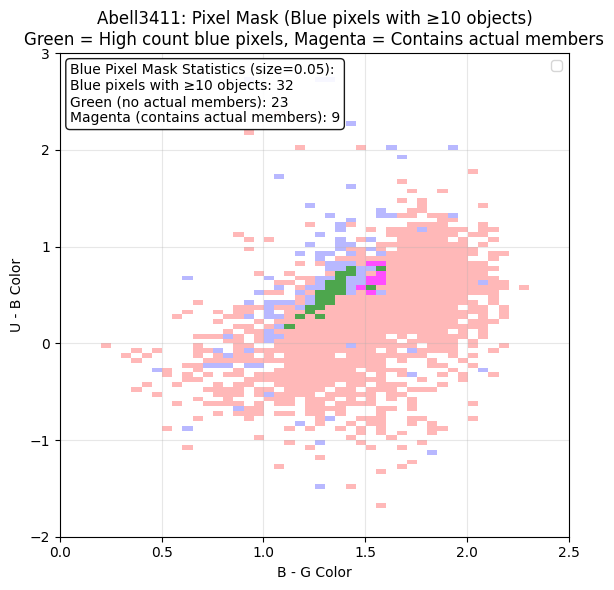


Blue Pixel Mask Analysis (≥10 objects per pixel):
Pixel size: 0.05
Blue pixels with ≥10 objects: 32
Green pixels (no actual members): 23
Magenta pixels (contains actual members): 9
Percentage with actual members: 28.1%


In [16]:
vote_map, x_edges, y_edges, bg_hist, fg_hist, total_objects = plot_pixel_voting_map(
    color_bg, color_ub, redshift, Z_THRESH, XLIM, YLIM,
    training_mask, CLUSTER_NAME,
    pixel_size=0.05,
    show_scatter=False,
    show_counts=False,
    show_mask=True,
    actual_catalog=Abell3411_actual,
    redshift_seq=False,           
    imposters_catalog=Abell3411_imposters,
    figsize=(6, 6)
)

## Write to File 

In [18]:

foreground_galaxies = apply_pixel_mask_to_catalog(
    vote_map_display=vote_map,
    x_edges=x_edges,
    y_edges=y_edges,
    full_catalog=full_cat,
    cluster_name=CLUSTER_NAME,
    pixel_size=0.1,
    show_mask=True,
    save_to=f{"/projects/mccleary_group/amit.m/color_fg_data/"}{},
    pixel_with_redseq=True,
    actual_catalog=Abell3411_actual
)

Found 8708 objects for Abell3411
Objects with valid colors: 8708
Added 26 unique red sequence members

Mask Application Results:
Total Abell3411 objects: 8708
Objects in masked pixels: 366 (4.2%)
  - In green pixels: 210
  - In magenta pixels: 156
Total foreground objects (including red sequence): 392

Saved 392 foreground galaxies to /projects/mccleary_group/amit.m/color_fg_data/Abell3411_foreground_pixel_and_redseq.fits


## Extra Stuff with the Fits File

### Plot the foreground objects in RADEC space

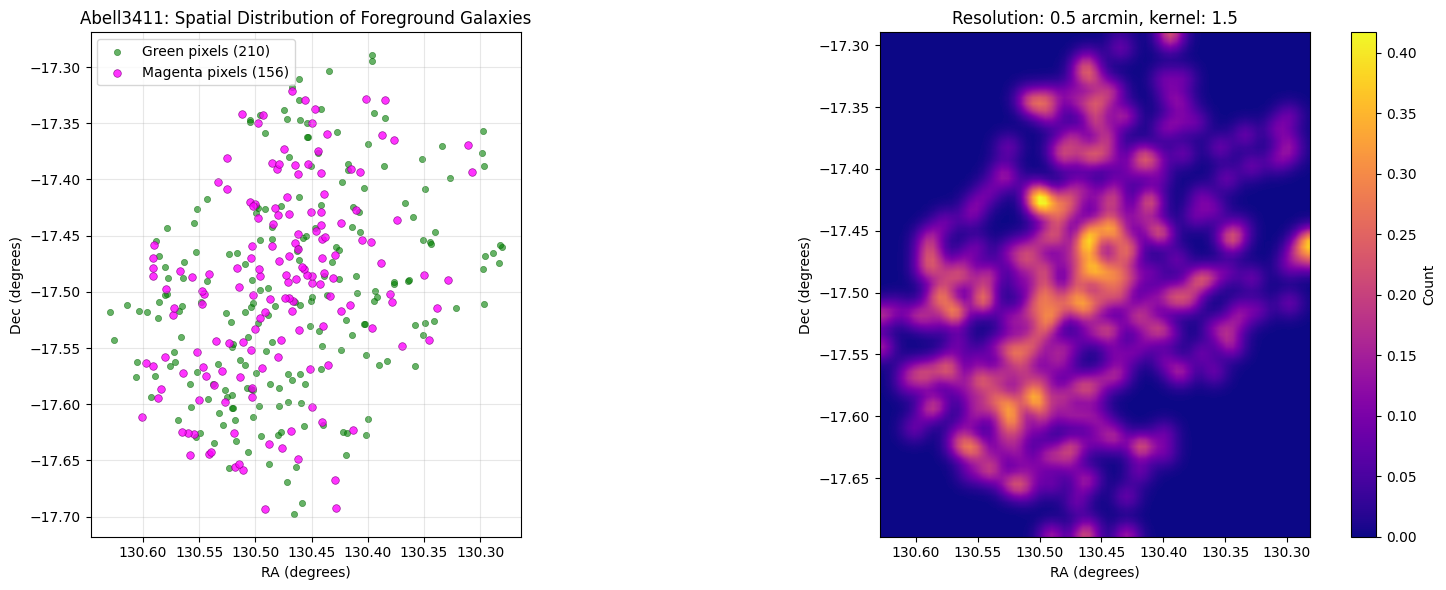

Loaded 392 foreground galaxies
Green pixels: 210, Magenta pixels: 156


In [19]:
result = spatial_plot('/projects/mccleary_group/amit.m/color_fg_data/Abell3411_foreground_pixel_and_redseq.fits', 
             vote_map, x_edges, y_edges, CLUSTER_NAME, include_members=False, actual_catalog = Abell3411_actual)

## Plot the Radius Distribution of the Foreground Objects 

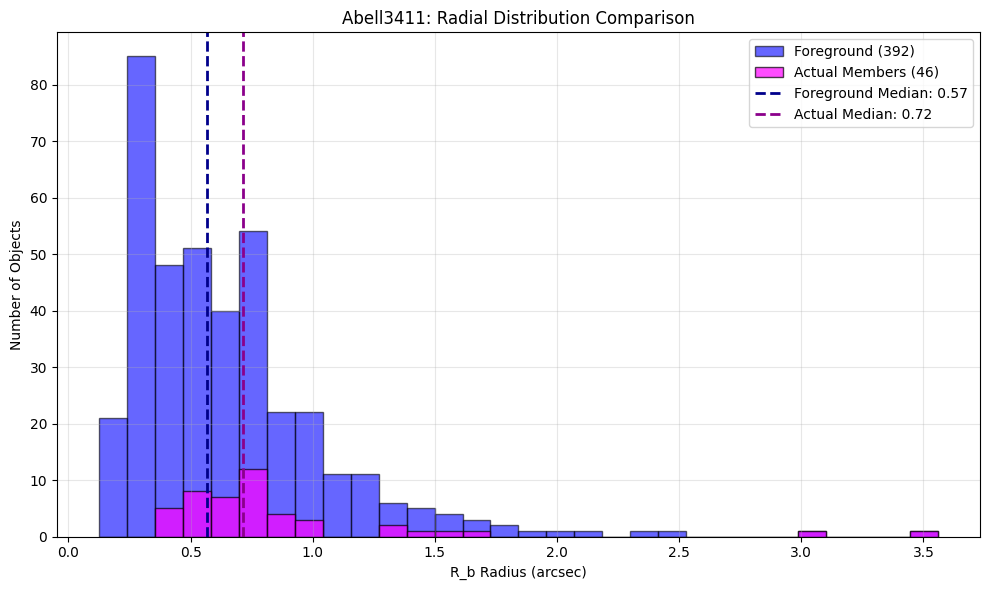

Foreground median radius: 0.57 arcsec
Actual members median radius: 0.72 arcsec


In [20]:

r_b_values = plot_radial_distribution_rb(
    '/projects/mccleary_group/amit.m/color_fg_data/Abell3411_foreground_pixel_and_redseq.fits',
    'Abell3411',
    actual_catalog=Abell3411_actual
)